<a href="https://colab.research.google.com/github/mhisle22/DSC-Covid-and-Census/blob/master/dsc305_covid_and_census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mark Hisle  
DSC 305  
Predicting Covid19 with the US Census Data

#Outline

This is an exploratory project aimed at using US Census data from 2017 to make observations on the spread of the novel virus COVID19 in the year 2020. Data is collected and processed from two different sources, both of which were taken from Kaggle: US Census Demographic Data, containing standard census data on US counties, and US counties COVID 19 dataset, a dataset taken from the New York Time's report on the number of cases and deaths caused by the virus in US counties since the first reports of cases in Washington state. All counties in the United States are accounted for, including data for Washington D.C. Links to the two datasets can be found below.

This project seeks to answer a few common questions on the spread of this virus using basic geographical data: 
* Are more populous counties more significantly affected?
* Is there a trend between the overall poverty/wealth of a country and its number of cases? This can be viewed with a number of variables taken from the census, such as poverty rate, income per capita, etc.
* Are certain states proportinoally more affected than others (i.e.- has the number of cases largely followed population, or are the preventative measures of certain state governments cause noticeable improvements? Are other factors involved (coastal, climate, border state, etc.))
* Is there a difference between men and women?
* Are counties with a higher proportion of commuters/work from home/walkers/transit users more affected?
* Does unemployement have a large affect on number of cases?
* Does the US classification of ethnicity (non-Hispanic white, Hispanic, Black, Asian, Native, Pacific Islander) cause noticeable differences?
* What trends can be observed over certain time periods

By aggregating, visualizing, and building several different statistical models with this data, we hope to give a general insight on whether Census data can be used to make predictions on the spread of this virus. 

At the time of the creation of this project (Spring 2020), data for the spread of the virus is still developing, as the COVID19 virus was still widespread within the country at the time. Because of this, the NYT US County COVID19 dataset continually gained new information. It is highly possible in the future that the virus will no longer be active in the US, and this data will no longer be in flux. In addition to this, assuming the virus will start to dissappear, completely new trends will appear later on, which will need separate analyses focusing on this new data.    
 
  
https://www.kaggle.com/muonneutrino/us-census-demographic-data   
https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset



In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics #for visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from yellowbrick.target import FeatureCorrelation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import itertools
import datetime
import pytz
import statsmodels.api as sm
import itertools
import warnings



%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Observation

In [2]:
from google.colab import files
import io

#locally upload the census data file
uploaded = files.upload() 

census = pd.read_csv(io.BytesIO(uploaded["acs2017_county_data.csv"]))
pd.set_option('display.max_columns', None) #necessary to handle huge amount of columns
census

Saving acs2017_county_data.csv to acs2017_county_data.csv


,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja Municipio,54754,26269,28485,96.7,3.1,0.1,0.0,0.0,0.0,42838,18900,1219,10197,576,43.8,49.4,28.6,20.2,25.9,11.1,14.2,92.0,4.2,0.9,1.4,0.6,0.9,31.6,14234,76.2,19.3,4.3,0.2,16.8
3216,72147,Puerto Rico,Vieques Municipio,8931,4351,4580,95.7,4.0,0.0,0.0,0.0,0.0,7045,16261,2414,11136,1459,36.8,68.2,20.9,38.4,16.4,16.9,7.3,76.3,16.9,0.0,5.0,0.0,1.7,14.9,2927,40.7,40.9,18.4,0.0,12.8
3217,72149,Puerto Rico,Villalba Municipio,23659,11510,12149,99.7,0.2,0.1,0.0,0.0,0.0,18053,19893,1935,10449,1619,50.0,67.9,22.5,21.2,22.7,14.1,19.5,83.1,11.8,0.1,2.1,0.0,2.8,28.4,6873,59.2,30.2,10.4,0.2,24.8
3218,72151,Puerto Rico,Yabucoa Municipio,35025,16984,18041,99.9,0.1,0.0,0.0,0.0,0.0,27523,15586,1467,8672,702,52.4,62.1,27.7,26.0,20.7,9.5,16.0,87.6,9.2,0.0,1.4,1.8,0.1,30.5,7878,62.7,30.9,6.3,0.0,25.4


First off, we have the US Census data taken from a local file. Although the actual metrics that the Census is measuring change on a daily basis, we will only be using data from 2017 for the purpose of this project. In this dataframe, we have a variety of useful data that people often cite concerning the spread of the virus, such as county population, ethnicity statistics, and poverty rate.

In [3]:
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
covid.tail(50)

,date,county,state,fips,cases,deaths
106776,2020-05-01,Monroe,Wisconsin,55081.0,14,1
106777,2020-05-01,Oconto,Wisconsin,55083.0,14,0
106778,2020-05-01,Oneida,Wisconsin,55085.0,6,0
106779,2020-05-01,Outagamie,Wisconsin,55087.0,62,2
106780,2020-05-01,Ozaukee,Wisconsin,55089.0,88,9
106781,2020-05-01,Pierce,Wisconsin,55093.0,10,0
106782,2020-05-01,Polk,Wisconsin,55095.0,4,0
106783,2020-05-01,Portage,Wisconsin,55097.0,5,0
106784,2020-05-01,Price,Wisconsin,55099.0,1,0
106785,2020-05-01,Racine,Wisconsin,55101.0,393,13


The COVID19 virus case data is taken from the New York Time's Github repository concerning the subject. This data is being updated on a daily basis at the time of this project, so logically it would make sense to frequently reload the data for this dataset. Here, the data is listed as follows: the date in which the certain point was collected, the county and State it represents, an FIPS id representing which US metro areas the county belongs to, and lastly, data for the number of cases and deaths in that county at the time.  

Now all that's left is to clean up the data a little, then merge the two sets together on their county data, then we will be ready to start creating models.


#Data Preparation



##Starting, Uncleaned Datasets

In [4]:
#remove all instances of the word county in the county column
census['County'] = census['County'].str.replace(' County', '').values
#likewise, Louisiana is special and lists counties as parishes
#They can't be doin' that
census['County'] = census['County'].str.replace(' Parish', '').values

#Puerto Rico is being dropped as the COVID df has no county data for it
#It also is a more unique region that would require separate analysis outside the scope of this project
census = census[census.State != 'Puerto Rico']

#dropping a few columns that will not be used in this project
census = census.drop(columns=['CountyId', 'VotingAgeCitizen', 'IncomeErr', 'IncomePerCapErr', 'Professional', 'Service', 'Office', 'Construction', 'Production',
                              'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Employed'])
census

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,ChildPoverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Alabama,Autauga,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,55317,27824,13.7,20.1,86.0,9.6,0.1,0.6,1.3,2.5,25.8,5.2
1,Alabama,Baldwin,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,52562,29364,11.8,16.1,84.7,7.6,0.1,0.8,1.1,5.6,27.0,5.5
2,Alabama,Barbour,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,33368,17561,27.2,44.9,83.4,11.1,0.3,2.2,1.7,1.3,23.4,12.4
3,Alabama,Bibb,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,43404,20911,15.2,26.6,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8.2
4,Alabama,Blount,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,47412,22021,15.6,25.4,86.8,10.2,0.1,0.4,0.4,2.1,35.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,44527,22981,21546,16.0,79.6,0.8,0.6,0.6,0.5,71083,31700,12.0,15.7,77.5,14.4,2.6,2.8,1.3,1.5,20.5,5.2
3138,Wyoming,Teton,22923,12169,10754,15.0,81.5,0.5,0.3,2.2,0.0,80049,49200,6.8,2.8,68.3,6.7,3.8,11.7,3.8,5.7,14.3,1.3
3139,Wyoming,Uinta,20758,10593,10165,9.1,87.7,0.1,0.9,0.1,0.0,54672,27115,14.9,20.0,77.4,14.9,3.3,1.1,1.3,2.0,19.9,6.4
3140,Wyoming,Washakie,8253,4118,4135,14.2,82.2,0.3,0.4,0.1,0.0,51362,27345,12.8,17.5,77.2,10.2,0.0,6.9,1.3,4.4,14.3,6.1


In [5]:
#check if any columns have missing or duplicate data, then fix
census.isna().any()
#ChildPoverty is missing data, which is fine since Poverty will suffice
census = census.drop(columns=['ChildPoverty'])

census[census.duplicated(keep='last')]
#no duplicates, thankfully
census

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Alabama,Autauga,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,55317,27824,13.7,86.0,9.6,0.1,0.6,1.3,2.5,25.8,5.2
1,Alabama,Baldwin,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,52562,29364,11.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,5.5
2,Alabama,Barbour,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,33368,17561,27.2,83.4,11.1,0.3,2.2,1.7,1.3,23.4,12.4
3,Alabama,Bibb,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,43404,20911,15.2,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8.2
4,Alabama,Blount,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,47412,22021,15.6,86.8,10.2,0.1,0.4,0.4,2.1,35.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,44527,22981,21546,16.0,79.6,0.8,0.6,0.6,0.5,71083,31700,12.0,77.5,14.4,2.6,2.8,1.3,1.5,20.5,5.2
3138,Wyoming,Teton,22923,12169,10754,15.0,81.5,0.5,0.3,2.2,0.0,80049,49200,6.8,68.3,6.7,3.8,11.7,3.8,5.7,14.3,1.3
3139,Wyoming,Uinta,20758,10593,10165,9.1,87.7,0.1,0.9,0.1,0.0,54672,27115,14.9,77.4,14.9,3.3,1.1,1.3,2.0,19.9,6.4
3140,Wyoming,Washakie,8253,4118,4135,14.2,82.2,0.3,0.4,0.1,0.0,51362,27345,12.8,77.2,10.2,0.0,6.9,1.3,4.4,14.3,6.1


In [6]:
#Now to fix up covid, mostly in the same way
#drop Puerto Rico
covid = covid[covid.state != 'Puerto Rico']

#drop  Northern Mariana Islands since there is very little data on this region
covid = covid[covid.state != 'Northern Mariana Islands']

covid.groupby('state').count() #check all states

#check if any columns have missing or duplicate data, then fix
covid.isna().any()

covid[covid.duplicated(keep='last')]
#no duplicates again

#all that's left is to rename some columns so they match Census
covid.columns = ['Date', 'County', 'State', 'fips', 'Cases', 'Deaths']
covid

,Date,County,State,fips,Cases,Deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
106821,2020-05-01,Sublette,Wyoming,56035.0,1,0
106822,2020-05-01,Sweetwater,Wyoming,56037.0,11,0
106823,2020-05-01,Teton,Wyoming,56039.0,65,1
106824,2020-05-01,Uinta,Wyoming,56041.0,6,0


In [7]:
#there are some COVID cases where the location of the patient is unknown- check these
covid[covid.County == 'Unknown']

,Date,County,State,fips,Cases,Deaths
418,2020-03-01,Unknown,Rhode Island,NaN,2,0
450,2020-03-02,Unknown,Rhode Island,NaN,2,0
485,2020-03-03,Unknown,Rhode Island,NaN,2,0
522,2020-03-04,Unknown,Rhode Island,NaN,2,0
569,2020-03-05,Unknown,Rhode Island,NaN,2,0
...,...,...,...,...,...,...
106081,2020-05-01,Unknown,Rhode Island,NaN,1104,132
106499,2020-05-01,Unknown,Utah,NaN,0,1
106515,2020-05-01,Unknown,Vermont,NaN,3,0
106519,2020-05-01,Unknown,Virgin Islands,NaN,66,4


##Merged Dataset

In [8]:
#Merge the two datasets on county
covid2 = covid.merge(census, on=['State', 'County'], how='outer')
covid2[covid2.State == 'Wyoming'].tail(50)
covid2

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,2020-01-21,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,2020-01-22,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,2020-01-23,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,2020-01-24,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,2020-01-25,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107023,NaN,Langlade,Wisconsin,NaN,NaN,NaN,19190.0,9709.0,9481.0,1.9,94.5,1.0,0.8,0.3,0.0,44122.0,25142.0,14.8,80.6,7.8,0.3,5.2,1.3,4.8,21.3,6.7
107024,NaN,Pepin,Wisconsin,NaN,NaN,NaN,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
107025,NaN,Taylor,Wisconsin,NaN,NaN,NaN,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
107026,NaN,Platte,Wyoming,NaN,NaN,NaN,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [9]:
#Some counties have no cases (THIS MAY CHANGE IN THE FUTURE.)
#Replace their dates with yesterday, cases and deaths with 0

#and then date has to be special

#localize today first, datetime is flawed
today = datetime.datetime.now(tz=pytz.timezone('US/Eastern')).date() #I spent way too much time trying to fix this, so don't ask
yesterday = today - datetime.timedelta(days=1)

#setup how columns should be changed
values = {'fips': 0, 'Cases': 0, 'Deaths': 0, 'Date': yesterday}

covid2.fillna(value=values, inplace=True) 
covid2

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,2020-01-21,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,2020-01-22,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,2020-01-23,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,2020-01-24,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,2020-01-25,Snohomish,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107023,2020-05-01,Langlade,Wisconsin,0.0,0.0,0.0,19190.0,9709.0,9481.0,1.9,94.5,1.0,0.8,0.3,0.0,44122.0,25142.0,14.8,80.6,7.8,0.3,5.2,1.3,4.8,21.3,6.7
107024,2020-05-01,Pepin,Wisconsin,0.0,0.0,0.0,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
107025,2020-05-01,Taylor,Wisconsin,0.0,0.0,0.0,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
107026,2020-05-01,Platte,Wyoming,0.0,0.0,0.0,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [10]:
#check one last time for any issues in the data
covid2.isna().any()

#there are "Unknown" counties, let's separate these out and hold on to them for later
#if needed they can easily be appended to the rest of the data
unknownCases = covid2[covid2.County == 'Unknown']
covid2 = covid2[covid2.County != 'Unknown']

covid2.isna().any()
covid2[covid2.isna().any(axis=1)]

,Date,County,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
1948,2020-03-01,New York City,New York,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,2020-03-02,New York City,New York,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,2020-03-03,New York City,New York,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,2020-03-04,New York City,New York,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2020-03-05,New York City,New York,0.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41018,2020-04-27,Kansas City,Missouri,0.0,500.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41019,2020-04-28,Kansas City,Missouri,0.0,511.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41020,2020-04-29,Kansas City,Missouri,0.0,520.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41021,2020-04-30,Kansas City,Missouri,0.0,545.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#a few smaller issues seem to occur with certain cities reporting individually instead of states, let's fix that

#first is new york city combining all its 5 counties into one city "county"
covid2[covid2.State == 'New York']
#we will take data from the census's website and directly insert it for New York City
#then remove the unused counties
#https://censusreporter.org/profiles/16000US3651000-new-york-ny/
#https://www.bls.gov/regions/new-york-new-jersey/data/xg-tables/ro2xgcesnyc.htm

covid2.set_index('County', inplace=True)
covid2.loc['New York City', 'TotalPop'] = 8398748
covid2.loc['New York City', 'Men'] = 4031399
covid2.loc['New York City', 'Women'] = 4367349
covid2.loc['New York City', 'Hispanic'] = 29.1
covid2.loc['New York City', 'White'] = 32.1
covid2.loc['New York City', 'Black'] = 24.3
covid2.loc['New York City', 'Native'] = 0.4
covid2.loc['New York City', 'Asian'] = 13.9
covid2.loc['New York City', 'Pacific'] = 0.1
covid2.loc['New York City', 'Income'] = 63799
covid2.loc['New York City', 'IncomePerCap'] = 39589
covid2.loc['New York City', 'Poverty'] = 18.9
covid2.loc['New York City', 'Drive'] = 22
covid2.loc['New York City', 'Carpool'] = 4
covid2.loc['New York City', 'Transit'] = 56
covid2.loc['New York City', 'Walk'] = 10
covid2.loc['New York City', 'OtherTransp'] = 3
covid2.loc['New York City', 'WorkAtHome'] = 5
covid2.loc['New York City', 'MeanCommute'] = 42
covid2.loc['New York City', 'Unemployment'] = 4.8

covid3 = covid2.reset_index()

#Kansas City and Anchorage also fall under this special case, 
#but since these cities are less significant to the overall dataset
#we will be leaving them out for the moment
covid3 = covid3[covid3.County != 'Kansas City']
covid3 = covid3[covid3.County != 'Anchorage']
covid3

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,County,Date,State,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment
0,Snohomish,2020-01-21,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
1,Snohomish,2020-01-22,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
2,Snohomish,2020-01-23,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
3,Snohomish,2020-01-24,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
4,Snohomish,2020-01-25,Washington,53061.0,1.0,0.0,771904.0,387078.0,384826.0,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,Langlade,2020-05-01,Wisconsin,0.0,0.0,0.0,19190.0,9709.0,9481.0,1.9,94.5,1.0,0.8,0.3,0.0,44122.0,25142.0,14.8,80.6,7.8,0.3,5.2,1.3,4.8,21.3,6.7
105952,Pepin,2020-05-01,Wisconsin,0.0,0.0,0.0,7282.0,3701.0,3581.0,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4
105953,Taylor,2020-05-01,Wisconsin,0.0,0.0,0.0,20344.0,10402.0,9942.0,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8
105954,Platte,2020-05-01,Wyoming,0.0,0.0,0.0,8703.0,4535.0,4168.0,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5


In [12]:
#Bronx, Kings, New York (Manhattan), Queens, and Richmond (Staten Island) can be dropped now since they have no data
covid3 = covid3[covid3.County != 'Bronx']
covid3 = covid3[covid3.County != 'Kings']
covid3 = covid3[covid3.County != 'New York']
covid3 = covid3[covid3.County != 'Queens']
covid3 = covid3[covid3.County != 'Richmond']

covid3.isna().any()

County          False
Date            False
State           False
fips            False
Cases           False
Deaths          False
TotalPop        False
Men             False
Women           False
Hispanic        False
White           False
Black           False
Native          False
Asian           False
Pacific         False
Income          False
IncomePerCap    False
Poverty         False
Drive           False
Carpool         False
Transit         False
Walk            False
OtherTransp     False
WorkAtHome      False
MeanCommute     False
Unemployment    False
dtype: bool

In [0]:
#men and women will be more useful to us as percentages, let's convert them

#convert men by dividing by population
covid3['Men'] = covid3.apply(lambda row: (row['Men'] / row['TotalPop']), axis=1)

#convert women by dividing by population
covid3['Women'] = covid3.apply(lambda row: (row['Women'] / row['TotalPop']), axis=1)

In [0]:
#One last thing- State isn't useful to us as text, let's make it a one-hot encode variable
#If you aren't familiar with one-hot encoding, look here: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
nonEncoded = covid3
covid3 = pd.get_dummies(covid3, columns=['State'])

In [15]:
#We are finally good to go, drop CountyId and we're ready to get cookin'
unconverted = covid3.copy()
covid = covid3
covid

,County,Date,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Hawaii,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,Snohomish,2020-01-21,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Snohomish,2020-01-22,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Snohomish,2020-01-23,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Snohomish,2020-01-24,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Snohomish,2020-01-25,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,Langlade,2020-05-01,0.0,0.0,0.0,19190.0,0.505941,0.494059,1.9,94.5,1.0,0.8,0.3,0.0,44122.0,25142.0,14.8,80.6,7.8,0.3,5.2,1.3,4.8,21.3,6.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
105952,Pepin,2020-05-01,0.0,0.0,0.0,7282.0,0.508239,0.491761,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
105953,Taylor,2020-05-01,0.0,0.0,0.0,20344.0,0.511306,0.488694,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
105954,Platte,2020-05-01,0.0,0.0,0.0,8703.0,0.521085,0.478915,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


After modifying the two datasets in a few ways, cleaning up any issues, and merging the two sets on County and State columns, we now have a complete dataset ready for model building. A few things to note before moving forward:

* Not all counties have data in the COVID dataset, as some counties have no reported cases of the virus. This may be due to either a true lack of cases in the county, or the reporting of cases in rural counties occuring in neighboring counties with more developed healthcare systems. Because of this, all rows representing these counties have been changed to the county name with 0 cases, 0 deaths, and marked on the previous day.   

NOTE: In the future, this grouping of counties may shrink or cease to exist as the virus spreads. However, at the time of writing, these cases were still present.

* There are reports in the COVID dataset of additional cases in certain states where the county of origin of multiple individuals is unknown. These data points will need to be treated separately, as they naturally provide no assistance to most models but will add clarity to models utilizing state more prominently.

* A few cities list cases as separate entities from the counties they represent, New York City being the most notable of these. Small adjusments were made to fix these data points

With all of this taken care of, we can begin to make observations of our data.

#Model Building and Observations

##First Tests

To start off, we will make a very basic linear regression model using every single column to predict cases. As this has no real direction, the results of this model will not mean much other than giving us a heads up of what to expect with other models. This will entail the "stretching" of a few data points to make them useful in this context, such as Date, which might be almost overly useful to this prediction.

In [0]:
#similarly, we should convert date to a number
regression = covid
regression['Date'] = pd.to_datetime(regression['Date']) 
regression['Date'] = (regression['Date'] - regression['Date'].min())  / np.timedelta64(1,'D')

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Cases']

#we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

y = regression['Cases']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)


In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
#Finally, we can make our very first model!
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9509919610104652
0.9580084397264638


The initial results on our simple linear model we see above are exceptional- clearly the data we have collected works quite well in determining the number of cases per county! However, this does not mean we have a perfect model that can be used to predict COVID19 cases in all scenarios- far from it. Many of the variables employed were far too "convenient" to be used in a real setting. Therefore, from here we will work to separate out what exactly does and does not matter when predicting cases, along with looking into the predicting of a few other variables.

##Digging in Deep with the Variables

To start off, we will start steping through the independent variables used to predict "Number of Cases" and see what trends we can find. As there are quite a few of them, we will do this in individual groups and see what we can find from there.

To start off, let's test all variables other than the one-hot encoded State variables, as these behave a bit differently.

In [20]:
#isolate out the names of the independent vars
features = np.array(covid.columns)
features = np.delete(features, [3]) #remove counts from this, since it's the dependent var
features = np.delete(features, [0]) #remove county since it is not currently included
features = np.delete(features, np.s_[23:]) #delete all states since there are too many, we will do them separately

features

array(['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'],
      dtype=object)

In [0]:
#fix up X as needed
independ = X.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5c8da5f8>,
                   feature_index=None, feature_names=None,
                   labels=array(['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'],
      dtype=object),
                   method='pearson', sort=True)

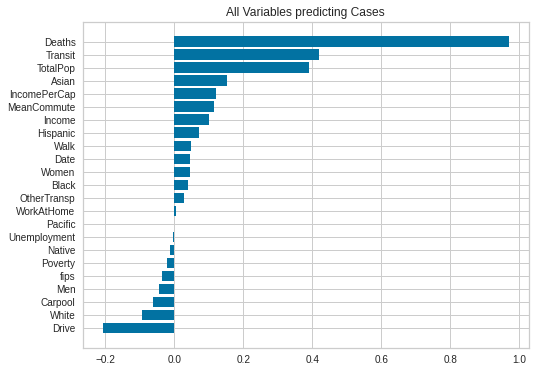

In [22]:
plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(independ, y)        # Fit the data to the visualizer

From this visualization of the correlation of each independent variable, we can draw a few preliminary points, some obvious and some quite interesting:

* Number of reported deaths has an obvious correlation to number of cases, as you will need to first contract the virus for this to take place.
* The population of a county has a high correlation to the number of cases within it. This makes logical sense based on how viruses spread in human populations.
* There is a slight corelation between Date and number of Cases. For the most part, this makes sense in that there is a correlation due to the general spread of the virus, along with its weakness, as there are still many counties who have few or even no reported cases
* Different sociological collected by the Census appear to have very interesting trends, so we will look into each of these similar groups further.

Now that we have a general sense of what we're looking at, let's make some individual groups of related variables and see what we can get.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5a0065f8>,
                   feature_index=None, feature_names=None,
                   labels=array(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'],
      dtype='<U8'),
                   method='pearson', sort=True)

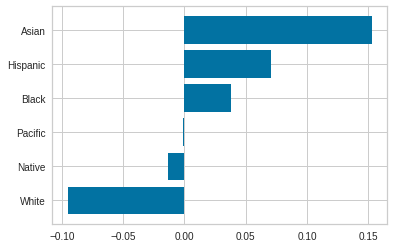

In [23]:
#start off with the ethnicity variables
#NOTE: the order here is not important, it simply follows the order of the Census
ethnicity = np.array(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'])

indEthnic = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women',
       'Income', 'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

visualizer = FeatureCorrelation(labels=ethnicity, sort=True)

visualizer.fit(indEthnic, y)

First off is our analysis between the ethnic makeup of counties and its correlation to number of cases. This is a particularly important subject when looking at this dataset, as many across the country have cited evidence that non-White communities are disproportionately affected by the virus.

From what we see above, our analysis would support this claim. There is a definitive correlation between the Asian population of a county and its number of cases, along with less strong positive correlations for both Hispanic and Black populations. Contrarily, there is a slight negative trend with Native American percentage and a strong negative trend for percentage White. There does not appear to be a correaltion with Pacific Islander population.

These trends are very important, as it would support the claims that several non-White groups are noticeably affected more than the White population, suggesting that underlying sociological issues are at play here. Therefore, this suggests that more work should be done to address this issue, and further analysis is necessary to understand what is taking place.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff59b2f4a8>,
                   feature_index=None, feature_names=None,
                   labels=array(['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute'], dtype='<U11'),
                   method='pearson', sort=True)

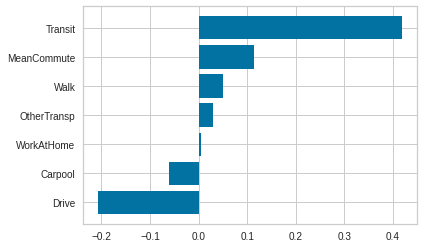

In [24]:
#now work and commute related
commute = np.array(['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute'])

indCommute = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Unemployment'])

visualizer = FeatureCorrelation(labels=commute, sort=True)

visualizer.fit(indCommute, y)

Next is our analysis of typical commuting-related variables within the Census.  
  
Here, there is a clear trend where counties with more users of public transit have a higher number of cases, whereas counties that have a population that primarily drives to work have a negative correlation with number of cases. The other variables here also directly support the claim that more urban cities, where people have the option to use transit or walk and opt to not drive, typically have more cases than less densely population counties. This makes logical sense, as these forms of commuting would lead to more exposure to other potentially infected people, whereas driving alone keeps you isolated.

Oddly enough, it does not appear that the "Work from Home" statistic appears to have had much of an effect on the model. This may be due to the fact that this variable is universally very low, but is interesting in the fact that this is one of the primary parts of social distancing strategies employed across the country.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff59aa3198>,
                   feature_index=None, feature_names=None,
                   labels=array(['Income', 'IncomePerCap', 'Poverty', 'Unemployment'], dtype='<U12'),
                   method='pearson', sort=True)

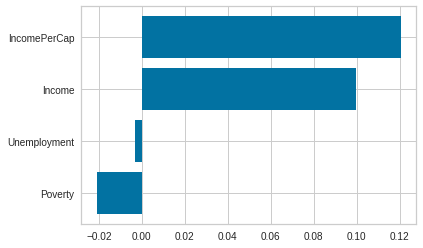

In [25]:
#economic variables
econ = np.array(['Income', 'IncomePerCap', 'Poverty', 'Unemployment'])

indEcon = independ.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute'])

visualizer = FeatureCorrelation(labels=econ, sort=True)

visualizer.fit(indEcon, y)

Here, we check for correlation between number of cases and the economic variables taken by the Census: Income per Capita, Average Income, the Unemployement rate and the Poverty Rate.  

Interestingly, there seems to be a correlation where more wealthy counties tend to have more cases, whereas counties with a higher level of poverty seem to have less. This could also be caused by an urban/rural divide, where wealth tends to be concentrated around larger cities in the US. However, this does not account for cities that may be poorer or wealthy rural communities. 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff59aaffd0>,
                   feature_index=None, feature_names=None,
                   labels=array(['TotalPop', 'Men', 'Women'], dtype='<U8'),
                   method='pearson', sort=True)

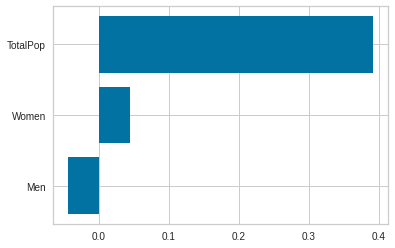

In [26]:
#general geographic variables
general = np.array(['TotalPop', 'Men', 'Women'])

indGen = independ.drop(columns=['Date', 'fips', 'Deaths', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

visualizer = FeatureCorrelation(labels=general, sort=True)

visualizer.fit(indGen, y)

Lastly, we check the remaining general census variables of Population, percentage Female and percentage Male.
   
Unsurprisingly once again, there is a clear correlation between population and number of cases, suggesting that a more populous county will have more cases.  
  
On the other hand, there seems to be a slight positive correlation between cases and counties with a higher percentage of women, while naturally there exists and inverse of this trend with men. This would support the claim that women may be disproportionately affect by the virus.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff59a712b0>,
                   feature_index=None, feature_names=None,
                   labels=array(['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'St...
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'], dtype=object),
                   method='pearson', sort=True)

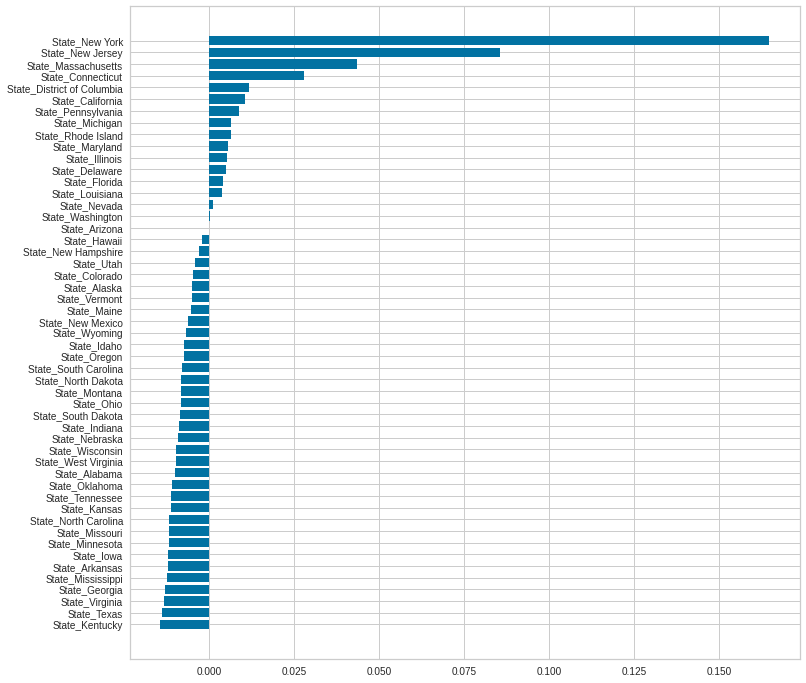

In [27]:
#lastly, state, which is its own style of analysis
features = np.array(covid.columns)
features = np.delete(features, [3]) #remove counts from this, since it's the dependent var
features = np.delete(features, [0]) #remove county since it is not currently included
features = np.delete(features, np.s_[:23]) #delete everyting BUT states

states = X.drop(columns=['Date', 'fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment'])

plt.subplots(figsize=(12, 12))
visualizer = FeatureCorrelation(labels=features, sort=True)

visualizer.fit(states, y)        # Fit the data to the visualizer

Unlike before, we cannot make simple assumptions about state data, as each state has quiet unique factors within itself that may lead to different trends, including population, density, level of international connectivity, along with the underlying issue of different levels of reaction to the virus. However, we can draw a few very general trends from this information:

* States that are the most affected by the virus naturally have a much higher correlation to number of cases than others, this being primarily New York and New Jersey, both of which are located within the worst outbreak in the county.

* Correlation does not match up exactly to where more populous states have a higher correlation. We can see this through some of the largest states, such as Texas, Georgia, and Virginia, all being located near the bottom of the above graph.

With all of this information, we will now attempt to find larger treds within the data by aggregating it in several different ways. This will give us further insight into some of the tredns we just saw.

##Macro Trends

The previous individual variable analysis provided us interesting information on what does and does not matter in building a model predicting cases, along with telling us a little about the nature of this pandemic. Now, we will attempt to discover any new trneds by aggregating the data in a few different ways. This will hopefully highlight a few interesting points, along with giving us further insight into the previous claims. 

First up will be our analysis of the data relative to each state consisting of all of its counties combined. 

In [28]:
#we will be using the non-encoded version of the dataset we made awhile back
#NOTE: this will only be cases on the most recent date- we will include time aggregations later
#In addition to this, a few less significant variables will be left out

states = nonEncoded
states['Date'] = pd.to_datetime(states['Date']) 

#remove all dates that aren't yesterday
selected_date = pd.date_range(today - pd.to_timedelta(1, unit='d'), today, freq='D')
states = states[states["Date"].isin(selected_date)]

stateCases = states.groupby("State")['Cases'].sum()
stateDeath = states.groupby("State")['Deaths'].sum()
statePop = states.groupby("State")['TotalPop'].sum()
stateMen = states.groupby("State")['Men'].mean()
stateWomen = states.groupby("State")['Women'].mean()
stateHispanic = states.groupby("State")['Hispanic'].mean()
stateWhite = states.groupby("State")['White'].mean()
stateBlack = states.groupby("State")['Black'].mean()
stateNative = states.groupby("State")['Native'].mean()
stateAsian = states.groupby("State")['Asian'].mean()
statePacific = states.groupby("State")['Pacific'].mean()
stateIncomeCap = states.groupby("State")['IncomePerCap'].mean()
statePoverty = states.groupby("State")['Poverty'].mean()
stateTransit = states.groupby("State")['Transit'].mean()
stateDrive = states.groupby("State")['Drive'].mean()

#now put them all back together
stateCases = stateCases.to_frame()
allStates = stateCases.merge(stateDeath, left_index=True, right_index=True)
allStates = allStates.merge(statePop, left_index=True, right_index=True)
allStates = allStates.merge(stateMen, left_index=True, right_index=True)
allStates = allStates.merge(stateWomen, left_index=True, right_index=True)
allStates = allStates.merge(stateHispanic, left_index=True, right_index=True)
allStates = allStates.merge(stateWhite, left_index=True, right_index=True)
allStates = allStates.merge(stateBlack, left_index=True, right_index=True)
allStates = allStates.merge(stateNative, left_index=True, right_index=True)
allStates = allStates.merge(stateAsian, left_index=True, right_index=True)
allStates = allStates.merge(statePacific, left_index=True, right_index=True)
allStates = allStates.merge(stateIncomeCap, left_index=True, right_index=True)
allStates = allStates.merge(statePoverty, left_index=True, right_index=True)
allStates = allStates.merge(stateTransit, left_index=True, right_index=True)
allStates = allStates.merge(stateDrive, left_index=True, right_index=True)

allStates

,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Poverty,Transit,Drive
State,,,,,,,,,,,,,,,
Alabama,7294.0,289.0,4850771.0,0.487016,0.512984,3.298507,65.168657,28.673134,0.607463,0.711940,0.017910,22180.492537,20.949254,0.220896,85.488060
Alaska,177.0,3.0,738565.0,0.538550,0.461450,5.093103,48.420690,1.179310,31.627586,5.982759,0.544828,31670.551724,13.555172,1.075862,47.024138
Arizona,7962.0,330.0,6809946.0,0.504501,0.495499,30.886667,50.826667,1.813333,13.233333,1.293333,0.126667,22712.200000,20.193333,0.973333,77.526667
Arkansas,3150.0,64.0,2977944.0,0.494146,0.505854,5.090667,75.634667,16.132000,0.540000,0.692000,0.077333,21449.306667,20.421333,0.286667,81.816000
California,52195.0,2146.0,38832664.0,0.505430,0.494570,29.656140,55.142105,2.892982,1.664912,7.131579,0.292982,30602.122807,15.647368,2.968421,73.503509
Colorado,15567.0,818.0,5435950.0,0.517746,0.482254,20.142857,74.476190,1.506349,0.836508,1.126984,0.115873,29659.079365,13.392063,1.620635,72.126984
Connecticut,28393.0,2337.0,3594478.0,0.492206,0.507794,11.425000,76.037500,6.475000,0.125000,3.575000,0.000000,39419.125000,9.200000,3.112500,80.050000
Delaware,4894.0,159.0,943732.0,0.483901,0.516099,8.533333,65.366667,20.100000,0.400000,2.866667,0.000000,31278.333333,12.300000,1.966667,82.000000
District of Columbia,4658.0,231.0,672391.0,0.474495,0.525505,10.700000,36.000000,46.900000,0.200000,3.700000,0.000000,50832.000000,17.400000,35.400000,34.000000


Now that we have a state-related dataset, we can build a new linear regression model centered around this, along with similar correlations comparisons to what we had before.

In [29]:
states.isna().any()

County          False
Date            False
State           False
fips            False
Cases           False
Deaths          False
TotalPop        False
Men             False
Women           False
Hispanic        False
White           False
Black           False
Native          False
Asian           False
Pacific         False
Income          False
IncomePerCap    False
Poverty         False
Drive           False
Carpool         False
Transit         False
Walk            False
OtherTransp     False
WorkAtHome      False
MeanCommute     False
Unemployment    False
dtype: bool

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = allStates.loc[:, allStates.columns != 'Cases']

y = allStates['Cases']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)


In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9842490927465526
0.9908132204327869


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5a002ac8>,
                   feature_index=None, feature_names=None,
                   labels=array(['Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'IncomePerCap', 'Poverty', 'Transit',
       'Drive'], dtype=object),
                   method='pearson', sort=True)

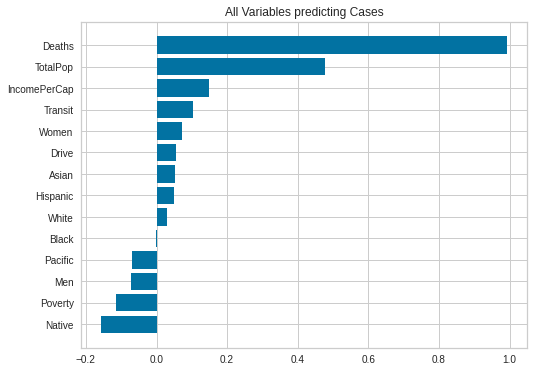

In [33]:
#isolate out the names of the independent vars
features = np.array(X.columns)

plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(X, y)        # Fit the data to the visualizer

Our state model has provided us with support for a few key ideas, while also challenging other concepts that we have seen. Interestingly, our state-only model seems to be much more accurate than the regular county-based model, despite having significantly less data points to train on. However, the lack of variety the state data has in comparison to the huge number of counties likely explains this fact.

For the most part, the highly correlating variables from before still hold to be important here: Deaths, Total Population, Income per Capita, and Transit usage all appear to be quite important to the model. However, what is interesting is the changes of a few variables from positive to negative and vice versa. For example, Percentage Women is now positively correlated, while Percentage Men is negatively correlated. Additionally, the general statistics upon ethnicity have changed. Although the most highly correlated categories from before (Asian, Hispanic) remain the same, the others are quite different, where White is now a positive correlation, Native quite negative, and Black now has little to no correlation at all.

Naturally, the changes above are caused by the differences in demographics between states and their individual counties- a state may have a diverse metropolitan area and be primarily rural outside of that, a state may be largely one ethnic group and have few to no urban area, etc. Ideally, a curious reader of this project could use both models and potentially make educated guesses on their own area based on both their state and neighboring counties.

After states, we will now look at different periods of time to look for any other unique trends.

In [34]:
#create a new column, week number, that records which week a date represents
unconverted['Date'] = pd.to_datetime(unconverted['Date'])

weeks = unconverted['Date'].dt.to_period('W-Mon').dt.week
unconverted['Week_Num'] = (weeks - weeks.min() + 1)
unconverted

,County,Date,fips,Cases,Deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Income,IncomePerCap,Poverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Unemployment,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Hawaii,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Week_Num
0,Snohomish,2020-01-21,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,Snohomish,2020-01-22,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,Snohomish,2020-01-23,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,Snohomish,2020-01-24,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,Snohomish,2020-01-25,53061.0,1.0,0.0,771904.0,0.501459,0.498541,9.8,71.2,2.6,0.8,9.9,0.5,78020.0,35737.0,8.8,74.7,11.4,5.3,1.7,1.6,5.2,31.8,5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,Langlade,2020-05-01,0.0,0.0,0.0,19190.0,0.505941,0.494059,1.9,94.5,1.0,0.8,0.3,0.0,44122.0,25142.0,14.8,80.6,7.8,0.3,5.2,1.3,4.8,21.3,6.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15
105952,Pepin,2020-05-01,0.0,0.0,0.0,7282.0,0.508239,0.491761,1.7,96.6,0.4,0.2,0.3,0.0,51470.0,27901.0,13.1,77.9,8.1,0.1,3.8,1.8,8.2,26.3,3.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15
105953,Taylor,2020-05-01,0.0,0.0,0.0,20344.0,0.511306,0.488694,1.8,96.4,0.5,0.2,0.2,0.0,49821.0,26290.0,10.9,75.3,9.8,0.4,3.6,2.1,8.9,22.6,3.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15
105954,Platte,2020-05-01,0.0,0.0,0.0,8703.0,0.521085,0.478915,7.8,89.2,0.0,0.0,0.5,0.0,47380.0,31242.0,10.5,75.6,8.8,0.3,3.9,1.3,10.1,16.9,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15


In [0]:
#now, redo what we did before, but with this column added in
#we will drop the old date column and see what is does
regression = unconverted.copy()
regression['Date'] = pd.to_datetime(regression['Date']) 
regression['Date'] = (regression['Date'] - regression['Date'].min())  / np.timedelta64(1,'D')

#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Cases']

#we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

#DROP OLD DATE
X = X.loc[:, X.columns != 'Date']

y = regression['Cases']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
#Finally, we can make our very first model!
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9509455603984002
0.9579674880840051


In [0]:
#fix up X as needed
independ = X.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff597c4940>,
                   feature_index=None, feature_names=None,
                   labels=array(['fips', 'Deaths', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White',
       'Black', 'Native', 'Asian', 'Pacific', 'Income', 'IncomePerCap',
       'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Unemployment', 'Week_Num'],
      dtype=object),
                   method='pearson', sort=True)

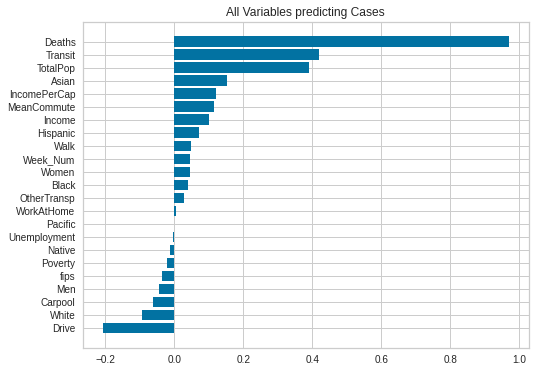

In [38]:
#isolate out the names of the independent vars
features = np.array(independ.columns)

plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(independ, y)        # Fit the data to the visualizer

From what we see here, it does not appear that utilizing a week number column is particularly useful in comparison to a regular date.

##A few more Models

The dataset still lends us to a few more models that predict variables other than Number of cases. Ideally, these models will show completely new insight into the datta that we had never seen before.

###Specific Applications

To start off, the logical first step would be to predict Deaths, using a linear model quite like before.

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Deaths']

#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

y = regression['Deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9453309115147227
0.9523329022745286


Our model appears to be ever so slightly less accurate than our original, although still very accurate. This indicates to us that Census data is useful for predicting both cases and deaths. However, as always, let us look at the individual variables to see if anything is different.

In [0]:
#fix up X as needed
independ = X.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5945b668>,
                   feature_index=None, feature_names=None,
                   labels=array(['Date', 'fips', 'Cases', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomePerCap', 'Poverty', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Unemployment',
       'Week_Num'], dtype=object),
                   method='pearson', sort=True)

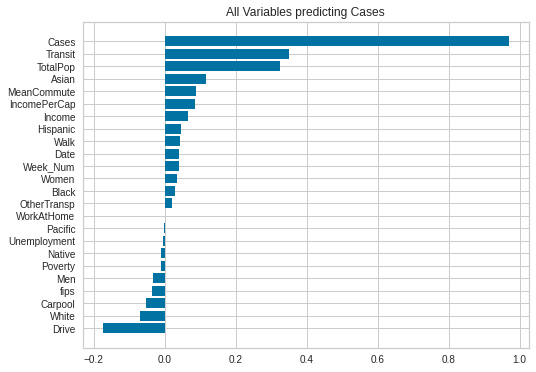

In [43]:
#isolate out the names of the independent vars
features = np.array(independ.columns)

plt.subplots(figsize=(8, 6)) #make the plot larger so we can actually see it
plt.title("All Variables predicting Cases")

visualizer = FeatureCorrelation(labels=features, sort=True)
visualizer.fit(independ, y)        # Fit the data to the visualizer

Unsurprisingly, there seems to be virtually no change in the correlation of variables between Cases and Deaths. This suggests that Cases and Deaths are largely tied together, once again making logical sense based on the nature of the virus.  

Next, just for fun, we will see if we can predict the "Date" using all of the information we have in our data frame. As there are many counties with little to no cases, we may not see much out of this.

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Date']

X = X.loc[:, X.columns != 'County']

y = regression['Date']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9785109566838049
0.9788364684764612


So our date predicting model does not appear to be particularly accurate, suggesting that cases, deaths, and the census information do not necessarily guarantee that we can know exactly what time we are looking at. This is not particularly surprising, as there is a high variance in cases depending upon a date- i.e. just because it is later in the year does not necessarily indicate that there will be more cases in all counties.

Lastly, we will explore the standard linear model predicting Cases, albeit without deaths. Since Deaths and Cases are so clearly tied together, let us check to see if our model is still useful without this variable.

In [0]:
#Separate dependent and independent variables, then split data into test and training sets
X = regression.loc[:, regression.columns != 'Cases']

#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable
counties = regression['County']
X = X.loc[:, X.columns != 'County']

#leaving out deaths, since that's the entire purpose of this part
X = X.loc[:, X.columns != 'Deaths']

y = regression['Cases']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
#We must scale the data before model building, as this greatly helps with accuracy and runtime
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.3113956742132592
0.3401882348232952


Alright, so as expected, Deaths clearly plays a significant role in this model in aiding to predict number of cases- the accuracy of our model has dropped substantially. From the above information, we can estimate that our Census variables provide us with a little over a quarter of all accuracy. Although this may seem problematic, it is to be expected- there is (at the time of this project) no way to perfectly  predict the spread of the virus without knowing information about the virus itself. In addition, this does not mean our model is without use- we still have access to current data for both cases and deaths. Which leads us to our next model...

From here, we will try something new- using an ARIMA model to extrapolate (in a controlled way) our data and make predictions for the future. 

###The ARIMA Model  

An ARIMA model, short for 'Auto Regressive Integrated Moving Average', attempts to explain a dataset based on a time series in order to make predictions about the future. While this would normally be thought of as incorrect due to its reliance on extrapolation, these types of models are specifically designed to "extrapolate", thus letting us make these predictions without worrying about invalidity of results.

A successful ARIMA model would be particularly useful to us in this project, as it will potentially allow for predictions to be made about the future spread of the virus. However, it is highly unlikely that our model will be particularly accurate, as it can only use data on previous total cases per day exclusively on one county. ***Unlike all other models before, this will not use any Census or County data, and is simply attempting to find a trend in the increase of cases. In this way, it is less serious than the other models and is more designed around seeing what is possible instead of being a complex piece of work.***

Let's start off by visualizing the data over the past weeks.

Text(0, 0.5, 'Cases')

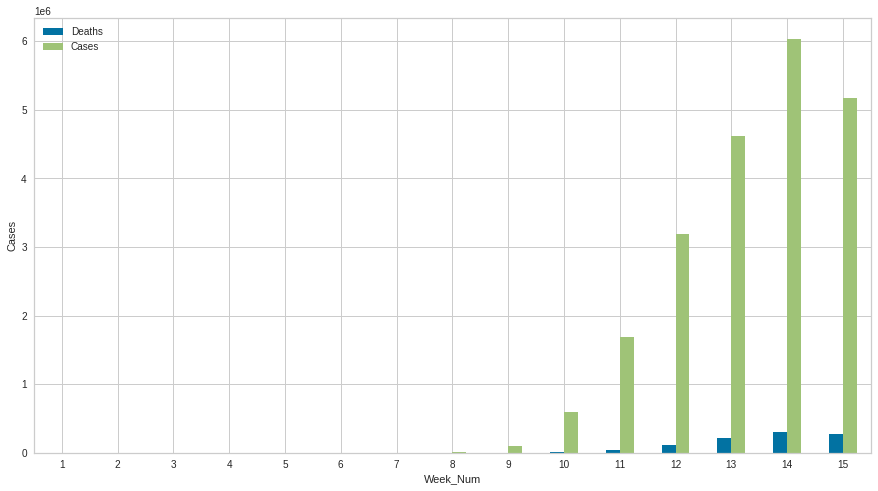

In [50]:
splitter = unconverted.copy()
splitter['Date'] = pd.to_datetime(splitter['Date'])

dates = splitter['Date']
counts = splitter['Cases']
deaths = splitter['Deaths']

aggregator = dates.to_frame()
aggregator = aggregator.merge(counts, left_index=True, right_index=True)
aggregator = aggregator.merge(deaths, left_index=True, right_index=True)


#NOTE: there will likely be a stub week at the end of the set, as the dataset continues to update
#since this will change every day, we will leave it as is
covidDt = aggregator.set_index('Date')
weeklyCovid = covidDt.resample('W').sum()
weeklyCovid = weeklyCovid.reset_index()

weeks = weeklyCovid['Date'].dt.to_period('W-Mon').dt.week
weeklyCovid['Week_Num'] = (weeks - weeks.min() + 1)


ax = weeklyCovid.plot.bar(x='Week_Num',y={'Cases', 'Deaths'}, rot=0,figsize=(15,8))
ax.set_ylabel("Cases")

At the moment, it appears that as time goes on, there will be an increase in cases to a high degree. Let's see if we can build a model that can determine this, along with perceived slowdowns or increases. We will ***only be building a model for cases in New York City***, as ***it cannot handle multiple dates from multiple different counties***.

There are a few steps we will have to do in order to find the most ideal ARIMA model for this project, the most important of which is selecting the best hyperparamters of p,d, and q for the model. A short explanation of each is found below (Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3): 

* p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

We will employ a technique similar to a grid-search in order to find the best possible combination for our dataset.

NOTE: In the future, it would be wise to allow this model to also take seasonality into account. However, at the time of development, there is only data for about 4 months concerning the virus, most of which are in the Spring. Because of this, seasonality will be left out.

In [51]:
#first, set our dataframe's index to the date column
arimaDF = unconverted.set_index('Date')

#Since we can only do one county at a time, let's start with NYC
arimaDF = arimaDF[arimaDF.County == 'New York City']
arima = arimaDF['Cases']
"""
#here, we will split up x and y, but we will not do a test-train split
#as it does not apply to ARIMA models- we are looking at an average over time
arimaX = arimaDF.loc[:, arimaDF.columns != 'Cases']

#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable
arimaX = arimaX.loc[:, arimaX.columns != 'County']

#drop most of the columns except for a few very useful ones
arimaX = arimaX.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District of Columbia', 'State_Florida',
       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming', 'fips', 'Men', 'Women', 'Hispanic', 'White',
       'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'Poverty', 'Drive', 'Carpool', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Unemployment', 'Week_Num'])

arima_y = arimaDF['Cases']

scaler = MinMaxScaler()
arimaX = scaler.fit_transform(arimaX)"""

"\n#here, we will split up x and y, but we will not do a test-train split\n#as it does not apply to ARIMA models- we are looking at an average over time\narimaX = arimaDF.loc[:, arimaDF.columns != 'Cases']\n\n#once again we will be leaving counties out for the moment, as it is more of an identifier than a variable\narimaX = arimaX.loc[:, arimaX.columns != 'County']\n\n#drop most of the columns except for a few very useful ones\narimaX = arimaX.drop(columns=['State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas',\n       'State_California', 'State_Colorado', 'State_Connecticut',\n       'State_Delaware', 'State_District of Columbia', 'State_Florida',\n       'State_Georgia', 'State_Hawaii', 'State_Idaho', 'State_Illinois',\n       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',\n       'State_Louisiana', 'State_Maine', 'State_Maryland',\n       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',\n       'State_Mississippi', 'State_Missouri', 'State_M

In [52]:
#now let's setup the hyperparamters and perform a grid search

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

#momentarily going to ignore warnings, api seems slighly over worried
warnings.filterwarnings("ignore") 

#grid search
for param in pdq:
    try:
        model = sm.tsa.ARIMA(arima, order=param)

        results = model.fit()

        print(param)
        print(results.aic)

    except:
        continue

warnings.filterwarnings("default")

(0, 0, 0)
1545.717285044069
(0, 0, 1)
1468.1659240141942
(0, 0, 3)
1335.4755530135005
(0, 1, 0)
1107.5661828734967
(0, 1, 1)
1066.5338464966915
(0, 1, 2)
1060.643779305889
(0, 1, 3)
1045.9015334790292
(0, 2, 0)
1015.6976795191417
(0, 2, 1)
1005.4533749352993
(0, 2, 2)
1007.0735248702482
(0, 2, 3)
1007.2331159977771
(1, 0, 0)
1210.1897802478104
(1, 1, 0)
1031.1572283690248
(1, 1, 1)
1024.5466430182682
(1, 1, 2)
1026.299120086488
(1, 1, 3)
1026.2232318088477
(1, 2, 0)
1010.7302794238531
(1, 2, 1)
1007.236988412925
(1, 2, 3)
1007.875936350541
(2, 0, 0)
1061.2556895325092
(2, 1, 0)
1028.3222560337601
(2, 1, 1)
1026.4167163346954
(2, 1, 3)
1026.9468295277209
(2, 2, 0)
1005.4619576689697
(2, 2, 1)
1007.2801408902633
(2, 2, 2)
1007.7981961393361
(2, 2, 3)
1009.7809542602814
(3, 0, 0)
1056.3600997384906
(3, 1, 0)
1024.2994905402397
(3, 1, 1)
1025.873339463134
(3, 1, 2)
1026.8710592270627
(3, 1, 3)
1017.5079592744637
(3, 2, 0)
1007.4015499031597
(3, 2, 1)
1009.329291281594
(3, 2, 2)
1009.771711

It appears that our best combination is (2,2,0), so we will use this going forward. NOTE: subject to change

In [53]:
mod = sm.tsa.ARIMA(arima, order=(2,2,0))

results = mod.fit()

#print(results.summary().tables[1])
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Cases   No. Observations:                   60
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -498.731
Method:                       css-mle   S.D. of innovations            982.718
Date:                Sat, 02 May 2020   AIC                           1005.462
Time:                        19:23:05   BIC                           1013.839
Sample:                    03-03-2020   HQIC                          1008.739
                         - 05-01-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             40.3898     72.271      0.559      0.578    -101.260     182.039
ar.L1.D2.Cases    -0.4415      0.121     -3.656      0.001      -0.678      -0.205
ar.L2.D2.Cases    -0.3325      0.119     -2.793      0.007      -0.566      -0.099
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6638           -1.6020j            1.7341           -0.3125
AR.2           -0.6638           +1.6020j            1.7341            0.3125
-----------------------------------------------------------------------------
"""

After creating our first ARIMA model model with a few of our census variables, we have received our first results. Looking at the P-value column, we can see that all our added variables have a p-value < .01, so we can definetely keep all of them for the time being, as they are useful to our model.  

Now we will attempt to evaluate this model further and use it to make predictions.

In [54]:
pred = results.predict(start=pd.to_datetime('2020-04-20'), dynamic=False)
#results.predict
pred_ci = results.conf_int()
pred

2020-04-20    496.662750
2020-04-21    674.906713
2020-04-22    272.891715
2020-04-23   -237.494187
2020-04-24   -258.973265
2020-04-25   -566.960978
2020-04-26   -337.561186
2020-04-27    728.472684
2020-04-28    972.204185
2020-04-29    543.904455
2020-04-30    -90.500652
2020-05-01   -204.874012
Freq: D, dtype: float64

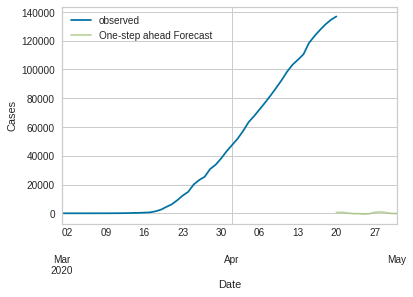

In [55]:
ax = arima[:'2020-04-20'].plot(label='observed')
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

"""ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)"""

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()

plt.show()

This model does not appear to be particularly good- it is predicting negative cases for the coming days, which is not possible in context. As another attept, we will use Statsmodel's SARIMAX model also to see if any better results are achieved

In [56]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#momentarily going to ignore warnings, api seems slighly over worried
warnings.filterwarnings("ignore") # specify to ignore warning messages

bestParam = "none"
bestSeas = "none"
bestAIC = 10000000000000
#grid search
for param in pdq:
    #for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arima,
                                            order=param,
     #                                       seasonal_order=param_seasonal,
                                            enforce_stationarity=False)

            results = mod.fit()

            print('ARIMA{}- AIC:{}'.format(param, results.aic))

            if(results.aic < bestAIC):
              bestAIC = results.aic
              bestParam = 'ARIMA{}'.format(param)
             # bestSeas = 'x{}12'.format(param_seasonal)

        except:
            continue

print("\n\nBest ones: ")
print(bestAIC,bestParam) #bestSeas)
warnings.filterwarnings("default")

ARIMA(0, 0, 0)- AIC:1563.8426268519925
ARIMA(0, 0, 1)- AIC:1498.1913053955725
ARIMA(0, 0, 2)- AIC:1468.6183412300932
ARIMA(0, 0, 3)- AIC:1281.9905108833952
ARIMA(0, 1, 0)- AIC:1151.0766246915437
ARIMA(0, 1, 1)- AIC:1075.8303367340607
ARIMA(0, 1, 2)- AIC:1041.958078431671
ARIMA(0, 1, 3)- AIC:1006.248404535743
ARIMA(0, 2, 0)- AIC:997.8929170964673
ARIMA(0, 2, 1)- AIC:972.3974402787735
ARIMA(0, 2, 2)- AIC:958.5629732155777
ARIMA(0, 2, 3)- AIC:942.5602240881241
ARIMA(0, 3, 0)- AIC:1038.760647601378
ARIMA(0, 3, 1)- AIC:970.6122097931343
ARIMA(0, 3, 2)- AIC:943.9337306138384
ARIMA(0, 3, 3)- AIC:927.8960580775911
ARIMA(1, 0, 0)- AIC:1113.4582802746006
ARIMA(1, 0, 1)- AIC:1065.2469294462585
ARIMA(1, 0, 2)- AIC:1048.8814585306593
ARIMA(1, 0, 3)- AIC:1000.8308854571127
ARIMA(1, 1, 0)- AIC:1014.4124460294834
ARIMA(1, 1, 1)- AIC:989.8669080315144
ARIMA(1, 1, 2)- AIC:976.2279112494269
ARIMA(1, 1, 3)- AIC:960.8455903227954
ARIMA(1, 2, 0)- AIC:993.0060168950477
ARIMA(1, 2, 1)- AIC:974.2536334462545
A

Here, our best model appears to be (1,3,3). Note: it appears that any pdq value above 4 leads to a lower AIC but much worse p-vals and results, this appears to be resultant of a form of overfitting.

In [57]:
mod = sm.tsa.statespace.SARIMAX(arima,
                                order=(1, 3, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5730      0.235     -2.442      0.015      -1.033      -0.113
ma.L1         -0.8683      0.218     -3.986      0.000      -1.295      -0.441
ma.L2         -0.6387      0.265     -2.413      0.016      -1.158      -0.120
ma.L3          0.6155      0.125      4.915      0.000       0.370       0.861
sigma2      1.022e+06   1.67e+05      6.103      0.000    6.94e+05    1.35e+06


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [0]:
pred = results.get_prediction(start=pd.to_datetime('2020-04-20'), dynamic=False)
pred_ci = pred.conf_int()

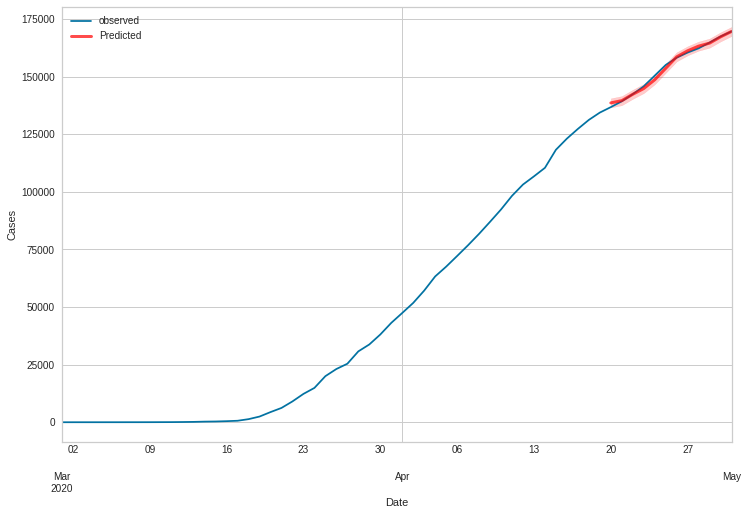

In [65]:
ax = arima.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(12,8), linewidth=3, color='Red')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='Red', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()

plt.show()

This predictor seems to follow much more closely than the last one. Now, let's see what it predicts for a week in the future, as predicting current values isn't too hard.

In [0]:
# Get forecast 7 steps (days) ahead in future
pred_uc = results.get_forecast(steps=7)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

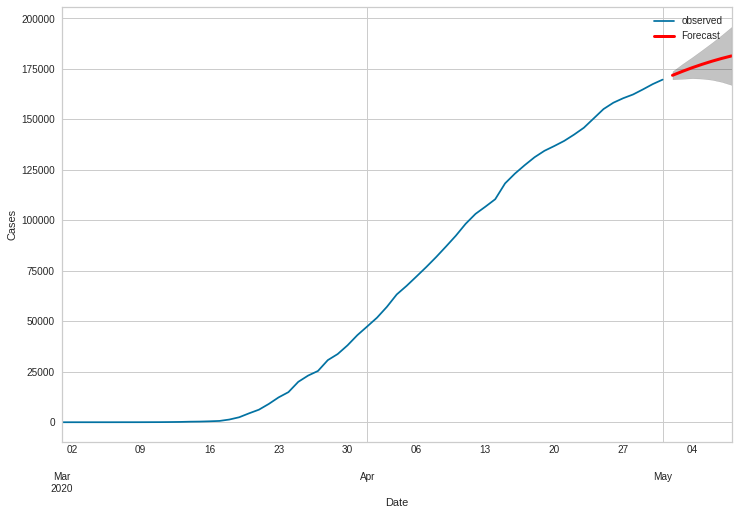

In [67]:
ax = arima.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth=3, color='Red')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')

plt.legend()
plt.show()

***Updated intermittently***

Journal keeping track of predictions over time:  

(4/26/2020)- It appears that our model is predicting a generally linear increase in number of cases in the coming week. 

(5/2/2020)- Predicting a slight increase in cases, with a possibilty of "flatenning of the curve".

#Conclusion

##Summary

The aim of this project was to use U.S. Census data to provide a new level of analysis for COVID19 spread data. Although several different topics were covered, the primary goal was to show correlation between basic census variables and number of cases per U.S. county. A short summary of the findings is as follows:

* There is indeed a correlation between Census data and coronavirus spread- at the time of writing, it can account for almost 35% of the variance in the number of cases per U.S. This percentage has increased over time

* Ethnicity has a noticeable correlation to number of cases per county, with the most correlation corresponding to Asians and Hispanics and a negative correlation to Whites

* There is a clear connection between cases and a rural/urban divide, measured by a number of variables listed below. In gereral, counties corresponding to larger cities will have many more cases than less populous areas. This corresponds with our general understanding of virus spread.

* Several commute related statistics, the most important of which being Public Transit Usage and Single-Passenger Car Usage, show correlation to cases, suggesting transportation forms that increase human contact spread the virus. This also supports the urban/rural divide claim.

* There is a negative correlation between income per capita and number of cases, suggesting wealthier counties are harder hit than poorer ones. This may also be accounted for by the urban/rural divide, as urban counties are often much wealthier.

* States seemed to be affected in a similar way to counties when combining all of their county data, where population, transit usage, ethnicity, still act in largely the same way when predicting number of cases.

* Number of cases and deaths per county are largely tied together- Census variables are not better/worse at predicting number of cases when compared to deaths, suggesting that counties will not have a proportionately higher or lower number of deaths based on demographics

* A basic ARIMA model was developed to predict number of cases in New York City over time. This was mostly experimental and separate from the Census data analysis.

This project has shown that there is a tie between U.S. demographic data and the spread of COVID19. While the primary statistic predicting number of cases over time is naturally the previous number of cases (more cases before means proportionately more cases in the future), the analysis above shows that the U.S. Census does indeed help in determining which counties and states will have more cases than others. This information will ideally aid in the builing of much more complex models in the future that could factor in these variables, as well as help inform the populace of the severity of their county's own situation.


##Further Work

As this is a currently developing and very popular data science problem, it is certain that major changes will take place with both this problem and how it will be viewed. The primary goal of this project was to show correlation between U.S. Census information and the spread of COVID19. However, there are both many different aspects of the problem tackled in this project as well as the situation in general that require further work. Some of these that are relevant to this project are:

* Age-related data used to determine spread and death
* Variables measuring levels of restriction on both a state and county level, which were constantly changing at the time of the project and diffcult to measure
* Ideally, using this dataset to measure a drop in cases/cure of the virus in the future
* Countries other than the U.S. could also be explored, as these demographic statistics may play very different roles within them
* Much more work could be done with ARIMA and other predictive models, as this is the primary area of interest in this problem at the time of the project
* Alternative model types used on this same dataset that were not covered in the project

As the pandemic continues to go on and more work is done on this topic, it is very likely that the data covered in this project will greatly change or new models and idea will come to replace this.